# Proyecto 2: EDA Ingresos Públicos de Brasil
## 3. Exploratory Data Analysis

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_csv("../datos/df_clean.csv", index_col=0)

In [4]:
df.columns

Index(['superior_body_code', 'name_superior_body', 'organ_code', 'organ_name',
       'management_unit_code', 'name_management_unit', 'economy_category',
       'source_revenue', 'recipe_species', 'detailing',
       'updated_estimated_value', 'value_launched', 'realized_value',
       'percentage_realized', 'release_date', 'financial_year',
       'economy_subcategory'],
      dtype='object')

### Distribución de ingresos por categoría económica

Vamos a crear un nuevo dataframe que contenga los ingresos por cateogoría económica.

In [5]:
df_value_per_category = df.groupby(["economy_category","economy_subcategory"])[["realized_value"]].sum()
df_value_per_category["percentage of total"] = (df_value_per_category["realized_value"]/df["realized_value"].dropna().sum()).round(4)

df_value_per_category

realized_value  percentage of total
economy_category    economy_subcategory                                     
Receitas Correntes  extra-orçamentárias    1.341424e+13               0.5073
                    intra-orçamentárias    2.808236e+11               0.0106
Receitas de Capital extra-orçamentárias    1.237381e+13               0.4680
                    intra-orçamentárias    2.142953e+10               0.0008
Sem informação      sem informação         3.498643e+11               0.0132

Vemos que ambas categorías principales (corrientes y de capital), reportan una proporción de ingresos totales comparable, aunque ligeramente superior en los ingresos corrientes, y que predominan aquellos que no son inter gubernamentales.

Ahora vamos a calcular la diferencia promedio entre ingresos previstos y realizados por categoría. Para ello crearemos una nueva columna en nuestro dataframe que contenga las diferencias entre estos datos.

In [128]:
df["difference_est_realized"] = (df["updated_estimated_value"]-df["realized_value"])
df_cat = df.groupby(["economy_category", "economy_subcategory"])[["difference_est_realized"]].mean()
df_cat

difference_est_realized
economy_category    economy_subcategory                         
Receitas Correntes  extra-orçamentárias            -4.778544e+05
                    intra-orçamentárias            -2.538572e+05
Receitas de Capital extra-orçamentárias             5.451779e+07
                    intra-orçamentárias            -1.106782e+08
Sem informação      sem informação                  3.935506e+07

Sin embargo, en secciones previas (limpieza de datos) podíamos observar muchos casos en los que el valor estimado era 0, por lo que el hecho de que tantos valores sean negativos se dan por este hecho. Vamos a calcular los casos donde el valor estimado no existe pero el realizado sí.

In [129]:
no_est_yes_realized = (df["updated_estimated_value"].isna() | df["updated_estimated_value"] == 0) & (df["realized_value"].notna() & df["realized_value"] != 0)
df_noest = df[no_est_yes_realized]
f'Las condiciones se cumplen en el {df_noest.shape[0]/df.shape[0]*100:.2f}% de los casos totales'

'Las condiciones se cumplen en el 92.46% de los casos totales'

Vemos que es un caso muy común. Esto puede ser porque estos ingresos no estuvieron planificados al inicio, y finalmente reportaron ingresos, o simplemente un error de registro. Si cogemos estos datos vemos que de hecho las medias de las diferencias disminuyen (más negativas) en todos los casos, indicando que es la principal fuente de estos datos tan negativos.

In [8]:
df_noest["difference_est_realized"] = (df_noest["updated_estimated_value"]-df_noest["realized_value"])
df_noest.groupby(["economy_category", "economy_subcategory"])[["difference_est_realized"]].mean()

C:\Users\yanru\AppData\Local\Temp\ipykernel_4044\1511455330.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_noest["difference_est_realized"] = (df_noest["updated_estimated_value"]-df_noest["realized_value"])


difference_est_realized
economy_category    economy_subcategory                         
Receitas Correntes  extra-orçamentárias            -1.121207e+07
                    intra-orçamentárias            -1.315709e+07
Receitas de Capital extra-orçamentárias            -3.530432e+08
                    intra-orçamentárias            -2.451876e+08
Sem informação      sem informação                 -1.620202e+07

Aclarar que cuanto más negativo, más retorno respecto a lo estimado.

Podemos realizar un análisis en los datos sin estos casos, el cual podría arrojar un poco más de luz en el análisis de las categorías, aunque hay que tener en cuenta que esta muestra representa menos de un 8% de los casos totales.

In [9]:
df_con_est = df[~no_est_yes_realized]
df_con_est["difference_est_realized"] = (df_con_est["updated_estimated_value"]-df_con_est["realized_value"])
df_con_est.groupby(["economy_category", "economy_subcategory"])[["difference_est_realized"]].mean()

C:\Users\yanru\AppData\Local\Temp\ipykernel_4044\3129268069.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_con_est["difference_est_realized"] = (df_con_est["updated_estimated_value"]-df_con_est["realized_value"])


difference_est_realized
economy_category    economy_subcategory                         
Receitas Correntes  extra-orçamentárias             4.256730e+08
                    intra-orçamentárias             2.198954e+08
Receitas de Capital extra-orçamentárias             7.437965e+09
                    intra-orçamentárias             5.404206e+09
Sem informação      sem informação                  1.341034e+09

Ahora los datos son todos positivos, lo cual indicaría que se ha recaudado en todos los casos una cantidad menor a la estimada inicialmente. Sin embargo, al igual que antes, registros donde sí que había una estimación pero no un valor realizado podrían estar detrás de estos valores tan grandes que obtenemos. Estos casos se podrían interpretar como registros donde se estimó una cantidad inicial que al final no recaudaron nada o simplemente, una vez más, un fallo en los registros. Una explicación más podría ser que este registro indica un ingreso aún no recibido, por lo que en el campo de valor realizado aparecería un vacío.

In [10]:
df_con_est_realized = df_con_est[(df_con_est["realized_value"] != 0) & (df_con_est["realized_value"].notna())]
df_con_est_realized["difference_est_realized"] = (df_con_est_realized["updated_estimated_value"]-df_con_est_realized["realized_value"])
df_con_est_realized.groupby(["economy_category", "economy_subcategory"])[["difference_est_realized"]].mean()

C:\Users\yanru\AppData\Local\Temp\ipykernel_4044\3219727869.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_con_est_realized["difference_est_realized"] = (df_con_est_realized["updated_estimated_value"]-df_con_est_realized["realized_value"])


difference_est_realized
economy_category    economy_subcategory                         
Receitas Correntes  extra-orçamentárias             4.505536e+08
                    intra-orçamentárias             1.193413e+08
Receitas de Capital extra-orçamentárias             2.129793e+10
                    intra-orçamentárias                      NaN
Sem informação      sem informação                  4.687883e+09

Vemos ahora que si cogemos solo datos con ambos registros de valores obtenemos algo bastante similar al caso anterior (casi todos en el mismo orden de magnitud). Esto puede indicar que los casos sin valor realizado no hayan supuesto un gran cambio con el caso anterior.

Como conclusión de este apartado, sería crucial investigar el origen de los valores 0 o nulos de las columnas de valor estimado y realizado, así como su significado en nuestros datos. Esto nos permitiría decidir si corresponde que se eliminen o se haga un análisis separado con éstos. 

Con el análisis realizado podríamos deducir que, sin descartar ningún registro, el gobierno brasileño consigue batir sus estimaciones en ingresos corrientes, tanto extra como inter gubernamentales, mientras que en los ingresos de capital ingresa menos de lo estimado, específicamente en los movimientos extra gubernamentales. Este suceso no ocurre en aquellos de interior.

Eliminando los registros sin estimación nos otorga unos resultados bastante diferentes, ya que en este caso ninguna categoría económica es capaz de ingresar más de lo estimado. De hecho, basado en estos datos, de media el gobierno tiene unos ingresos bastante más bajos a lo que estiman, a lo largo de todas las categorías. Cabe indicar que, como ha sido mencionado previamente, estos datos podrían no ser representativos de la realidad, ya que no tenemos información suficiente sobre los vacíos ni los 0 en ninguno de los valores, tanto estimados como realizados.

### Análisis Temporal

Podemos realizar varios tipos de análisis temporales: anuales y mensuales. 

Anualmente, haremos un análisis de la suma de valor realizado y compararemos con otros años. De esta forma, podremos observar la evolución en los ingresos del país, lo cual podría ser uno de los indicadores de crecimiento económico.

In [19]:
df_yearly = df.groupby(["financial_year", "economy_category"])["realized_value"].sum().reset_index()

C:\Users\yanru\AppData\Local\Temp\ipykernel_4044\3022998853.py:4: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', False)` for the same effect.

  sns.lineplot(data = df_yearly, x = "financial_year", y = "realized_value",
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


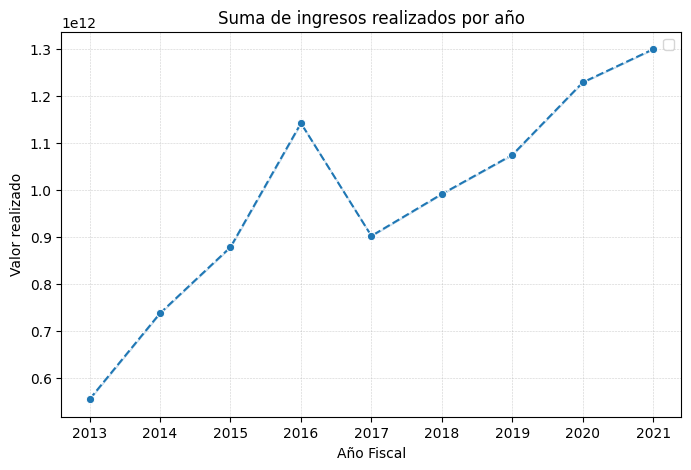

In [90]:
plt.figure(figsize=(8,5))
plt.title("Suma de ingresos realizados por año")
plt.grid(ls = "--", lw = 0.4, alpha = 0.6)
sns.lineplot(data = df_yearly, x = "financial_year", y = "realized_value", 
              ci = False, marker = "o", ls = "--")
plt.xlabel("Año Fiscal")
plt.ylabel("Valor realizado")
plt.legend()
plt.show()

Con esta primera gráfica tenemos una visión general de cómo evolucionan los ingresos anuales de Brasil. Vemos una subida consistente hasta el año 2016, y luego un desplome en el siguiente año. Tras una búsqueda, una de las causas de esta bajada podría ser la corrupción y la huelga general brasileña en la que estuvo envuelta el país en 2017, lo cual explicaría la reducción drástica en la cantidad recaudada, y suponiendo un bajón en la economía que tardaría 3 años en remontar.

Por otra parte también es interesante separar esta línea en las categorías económicas que la conforman.

C:\Users\yanru\AppData\Local\Temp\ipykernel_4044\1815130759.py:4: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', False)` for the same effect.

  sns.lineplot(data = df_yearly, x = "financial_year", y = "realized_value", hue = "economy_category",


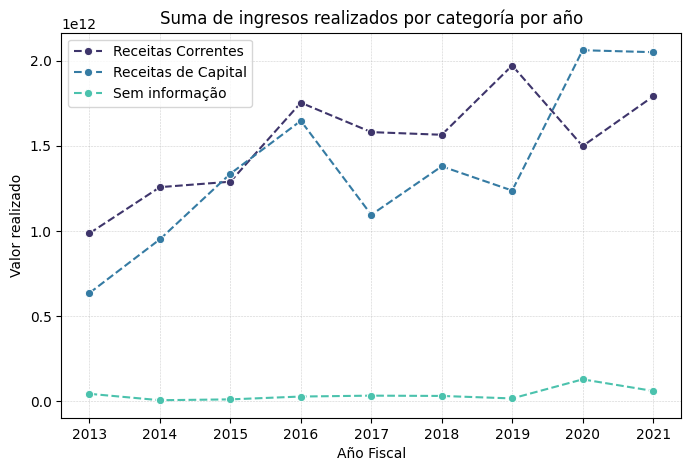

In [93]:
plt.figure(figsize=(8,5))
plt.title("Suma de ingresos realizados por categoría por año")
plt.grid(ls = "--", lw = 0.4, alpha = 0.6)
sns.lineplot(data = df_yearly, x = "financial_year", y = "realized_value", hue = "economy_category",
              ci = False, marker = "o", ls = "--", palette="mako")
plt.xlabel("Año Fiscal")
plt.ylabel("Valor realizado")
plt.legend()
plt.show()

Aquí también se observa la bajada de 2017 en ambas categorías principales, aunque las tendencias en los años posteriores a éste no siguen el mismo patrón.

Ahora, para el análisis mensual tenemos dos opciones: aplicar una suma por meses de los ingresos realizados o una media. Cada una de estas métricas nos aportará información diferente. La suma permite observar la magnitud total del valor realizado, mientras que una media podrá arrojar información sobre el comportamiento promedio. De igual forma, ambas tienen sus limitaciones. Con la suma podemos ser susceptibles a un año donde los ingresos en ciertos meses fueron muy distintos a las de otros, provocando que esta suba o baje, mientras que con la media podemos tener muchos valores atípicos que la hagan variar drásticamente.

In [78]:
df["month"] = pd.to_datetime(df["release_date"]).dt.month_name()

In [79]:
import calendar
month_names = list(calendar.month_name)[1:]

In [110]:
df_monthly = df.groupby(["month", "economy_category"])["realized_value"].agg(["sum", "mean", "median"]).reset_index().sort_values("month")
df_monthly["month"] = pd.Categorical(df_monthly["month"], categories=month_names, ordered=True)
df_monthly = df_monthly.sort_values("month")

In [113]:
df_monthly

,month,economy_category,sum,mean,median
14,January,Sem informação,6.563810e+09,4.049235e+06,2568.000
13,January,Receitas de Capital,7.838195e+11,2.974647e+08,17391.740
12,January,Receitas Correntes,1.042105e+12,1.257002e+07,2112.415
11,February,Sem informação,2.880572e+10,1.921662e+07,2864.940
10,February,Receitas de Capital,5.013235e+11,2.924874e+08,70554.060
9,February,Receitas Correntes,6.264869e+11,8.797244e+06,2874.370
21,March,Receitas Correntes,1.085886e+12,1.348575e+07,2922.600
23,March,Sem informação,1.267875e+10,7.768842e+06,3518.670
22,March,Receitas de Capital,8.480218e+11,4.065301e+08,81171.955
0,April,Receitas Correntes,8.313799e+11,1.117566e+07,2852.380


C:\Users\yanru\AppData\Local\Temp\ipykernel_4044\3964923246.py:4: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', False)` for the same effect.

  sns.lineplot(data = df_monthly, x = "month", y = "sum", hue = "economy_category",


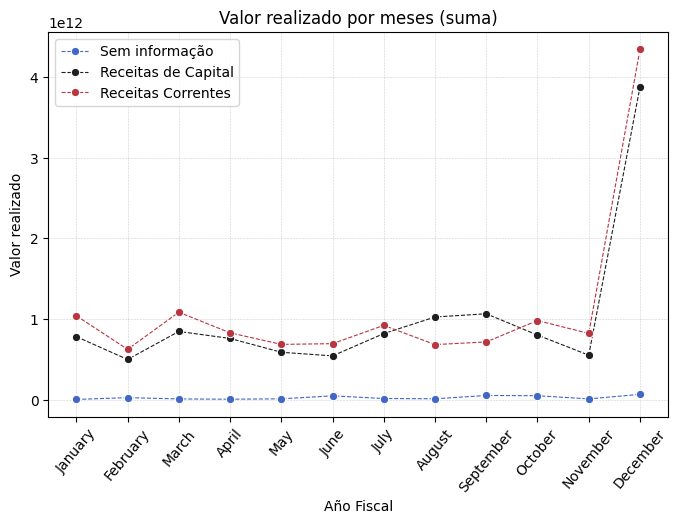

In [106]:
plt.figure(figsize=(8,5))
plt.grid(ls = "--", lw = 0.4, alpha = 0.6)
plt.title("Valor realizado por meses (suma)")
sns.lineplot(data = df_monthly, x = "month", y = "sum", hue = "economy_category",
             ci = False, marker = "o", ls = "--", palette="icefire", lw = 0.8)
plt.xlabel("Año Fiscal")
plt.ylabel("Valor realizado")
plt.legend()
plt.xticks(rotation = 50)
plt.show()

Una suma muestra un patrón de aumento claro en diciembre. Esto podría explicarse al ser el final de un período fiscal, y es cuando más se recauda al ser una fecha límite. De esta forma los ingresos se dispararían para final de año y volverían a niveles estándar en el mes siguiente.

C:\Users\yanru\AppData\Local\Temp\ipykernel_4044\2096230597.py:4: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', False)` for the same effect.

  sns.lineplot(data = df_monthly, x = "month", y = "mean", hue = "economy_category",


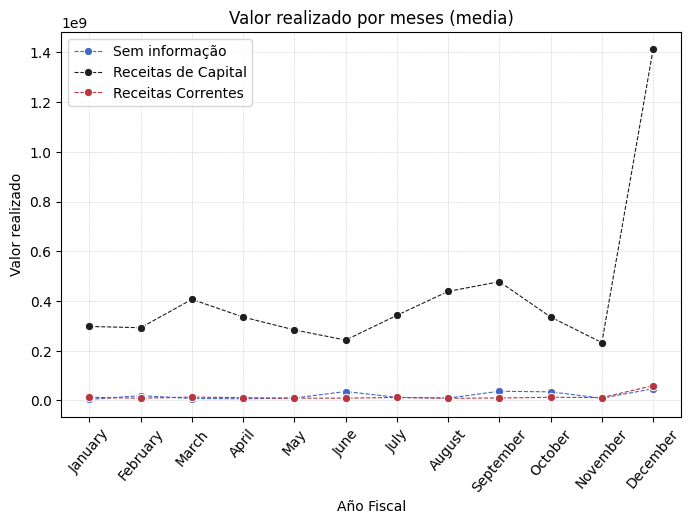

In [107]:
plt.figure(figsize=(8,5))
plt.grid(ls = "--", lw = 0.4, alpha = 0.6)
plt.title("Valor realizado por meses (media)")
sns.lineplot(data = df_monthly, x = "month", y = "mean", hue = "economy_category",
             ci = False, marker = "o", ls = "--", palette="icefire", lw = 0.8)
plt.xlabel("Año Fiscal")
plt.ylabel("Valor realizado")
plt.legend()
plt.xticks(rotation = 50)
plt.show()

Al hacer la media, obtenemos la misma tendencia para los ingresos de capital, pero no para los ingresos corrientes. Esto puede ser por lo anteriormente mencionado. La media es muy susceptible a valores atípicos y en este caso pueden haber muchos por debajo.

Uno podría pensar que la mediana sería una medida más robusta, la cual sería menos influenciable por valores atípicos y que podría describir en buena medida el comportamiento por meses de los ingresos.

C:\Users\yanru\AppData\Local\Temp\ipykernel_4044\4213710516.py:4: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', False)` for the same effect.

  sns.lineplot(data = df_monthly, x = "month", y = "median", hue = "economy_category",


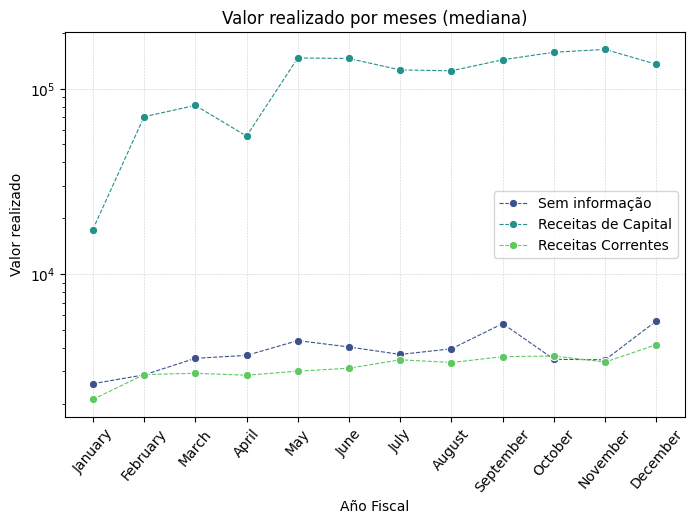

In [115]:
plt.figure(figsize=(8,5))
plt.grid(ls = "--", lw = 0.4, alpha = 0.6)
plt.title("Valor realizado por meses (mediana)")
sns.lineplot(data = df_monthly, x = "month", y = "median", hue = "economy_category",
             ci = False, marker = "o", ls = "--", palette="viridis", lw = 0.8)
plt.xlabel("Año Fiscal")
plt.ylabel("Valor realizado")
plt.legend()
plt.xticks(rotation = 50)
plt.yscale("log")
plt.show()

Sin embargo aquí los datos son difícilmente interpretables. Una tendencia que sigue existiendo sería el inicio de año con ingresos bajos, lo cual tiene sentido al ser el inicio del año fiscal. Para los ingresos corrientes sigue viéndose un aumento (a escala log). Si comprobáramos las medianas solo por meses:

In [126]:
df_median = df.groupby("month")["realized_value"].median().reset_index()
df_median["month"] = pd.Categorical(df_median["month"], categories=month_names, ordered=True)
df_median.sort_values("month")

,month,realized_value
4,January,2200.225
3,February,3050.000
7,March,3128.220
0,April,3013.500
8,May,3252.170
6,June,3361.700
5,July,3750.000
1,August,3598.770
11,September,3903.420
10,October,3920.260


Aquí vuelve el patrón inicial. Los ingresos se disparan a final de año.

La conclusión a la que se llega sigue siendo la misma, en diciembre los ingresos se disparan por el cierre del año fiscal.

### Identificación de discrepancias

Con los datos del primer apartado se ve que, en todos los casos, los ingresos de capital son los que más difieren entre estimación y realización. Ahora analicemos cuál es el cuerpo superior con mayor diferencia.

In [191]:
df_capital_supbod_median = df.groupby(["economy_category","name_superior_body"])[["difference_est_realized"]].median()
df_capital_supbod_mean = df.groupby(["economy_category","name_superior_body"])[["difference_est_realized"]].mean()

In [200]:
print(df_capital_supbod_median["difference_est_realized"].abs().nlargest(5))
print("------------------------------------------------------------------------------")
print(df_capital_supbod_mean["difference_est_realized"].abs().nlargest(5))

economy_category     name_superior_body                           
Receitas de Capital  Ministério da Mulher, Família e Direitos Huma    8.626670e+07
                     Ministério da Previdência Social                 4.444500e+06
                     Ministério da Economia                           3.621776e+06
                     Controladoria-Geral da União                     2.559536e+06
                     Advocacia-Geral da União                         2.300000e+06
Name: difference_est_realized, dtype: float64
------------------------------------------------------------------------------
economy_category     name_superior_body                
Receitas de Capital  Ministério da Cidadania               1.614154e+09
                     Advocacia-Geral da União              4.978293e+08
                     Ministério das Relações Exteriores    4.354110e+08
Sem informação       Ministério da Economia                1.704377e+08
Receitas de Capital  Ministério da Economia      

Realizamos dos agrupaciones, con mediana y media. La decisión de usar ambos se toma para poder comparar entre ambos métodos, ya que la media es más robusta frente a valores atípicos, pero si hay un exceso de ellos puede dejar de ser útil, y la media tiene una gran sensibilidad ante estos, pero a la hora de ver una visión general puede ser útil, sobretodo comparando con la mediana.

De esta forma vemos que, aunque estas dos métricas difieran entre los cuerpos que presentan mayor diferencia, el Ministerio de Economía es consistente en ambos, lo que puede sugerir que es de los que mayor diferencia presentan.

Aclarar que se ha hecho uso del valor absoluto, de tal forma que tanto aquellos que suelen superar con creces la estimación y aquellos que no la alcanzan sean incluidos en esta comparación, ya que es importante que las fuentes de ingresos tengan una correcta predicción.